# **Guide to use pytwovision package**

In [ ]:
import sys
import os
import glob
import cv2 as cv
import json
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button

In [3]:
!pip install py2vision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 689 kB/s 
     |████████████████████████████████| 15.7 MB 14.7 MB/s 
     |████████████████████████████████| 668.3 MB 15 kB/s 
     |████████████████████████████████| 462 kB 78.3 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=09d288292a8f0d8f3f23e5f102b121ee04db5c795b1bbfe3f0f4f1c939e4bc25
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949


In [4]:
from py2vision.input_output.camera import Camera
from py2vision.stereo.standard_stereo import StandardStereo
from py2vision.stereo.standard_stereo import StandardStereoBuilder
from py2vision.stereo.match_method import Matcher
from py2vision.stereo.match_method import StereoSGBM
from py2vision.stereo.stereo_builder import StereoController

# Lesson 1: Calibrate a Stereo pair of cameras
In this lesson you will learn how to use:

- Camera(id, source)

> - id id: A string to identify our camera.
> - source: When you use webcam you need to put (int) 0, if you want to use videos or streaming, you will need to put his URL or path even you can put in a video file or a image path.

- StandardStereo(cam_left: Camera, cam_right: Camera, fish_eye=True)

> - cam_left: left camera instance.
> - cam_right: right camera instance.
> - fish_eye: A boolean if is true it will calibrate with cv2.fisheye.calibrate if no it'll use normal calibration, fish eye is recomended when cameras has an field of view (FOV) > 160.

To calibrate an stereo Pair and get its **RMS error** to know when a calibration is good your RMS error has to be less than 1.


### First we're gonna create our cameras instances

In [5]:
left_camera = Camera("left_camera", "imx_219_A")
right_camera = Camera("right_camera", "imx_219_B")

### Now calibrate 
You should know something before about the method 

> **calibrate(images_left_path, images_right_path, pattern_type='chessboard', pattern_size=(8,5), show=True)**

> Arguments:
- images_left_path: folder where is saved left calibration pattern photos.
- images_right_path: folder where is saved right calibration pattern photos.
- pattern_type: It can be "circles" pattern or "chessboard" pattern (default).
- pattern_size: If pattern_type is "chessboard"  this the Number of inner corners per a chessboard row and column. But If pattern_type is "circles" this will be the number of circles per row and column. 
- show: if is true it show corners or centers found by calibration algorithm at each iteration.

> **Returns**: Three floats, The first is the reprojection error in left side,  the other is right side and the third is rms error (these have to be less than 1)

Note: if you want a good calibration your images in **images_left_path** and **images_right_path** have to follow a format for example: **example/left_images/photo_1.jpg** and **example/right_images/photo_1.jpg**  the number is important because calibrate method order the pair of images with sorted method.


In [6]:
stereo_pair = StandardStereo(left_camera, right_camera)
error_l, error_r, rms_error = stereo_pair.calibrate("LEFT_CAMERA_CALIBRATION_IMAGES_FOLDER", "RIGHT_CAMERA_CALIBRATION_IMAGES_FOLDER", show=False)

Calibrating estereo...
Camera parameters hasn't fixed
Fixing left camera...
Left camera error 0.196044268885419
Fixing Right camera...
Right camera error 0.18532068709086463
Calibrating estereo...
system calibrated


In [7]:
print("Calibration error (left camera): {}".format(error_l))
print("Calibration error (right camera): {}".format(error_r))
print("Stereo Calibration error: {}".format(rms_error))
stereo_pair.print_parameters()

Calibration error (left camera): 0.196044268885419
Calibration error (right camera): 0.18532068709086463
Stereo Calibration error: 0.2118487023885627
Left camera:
dist_coeffs : [[-0.02052823]
 [ 0.10633761]
 [-0.89543581]
 [ 1.67850114]]
matrix : [[309.27979139   0.         346.02689527]
 [  0.         462.11985879 374.74264457]
 [  0.           0.           1.        ]]


Right camera:
dist_coeffs : [[-0.02052823]
 [ 0.10633761]
 [-0.89543581]
 [ 1.67850114]]
matrix : [[309.27979139   0.         346.02689527]
 [  0.         462.11985879 374.74264457]
 [  0.           0.           1.        ]]


Stereo:
rot : [[ 0.99988568 -0.01454588  0.00412826]
 [ 0.01465657  0.99949522 -0.02818675]
 [-0.00371617  0.02824404  0.99959415]]
trans : [[2.46141938]
 [0.00361231]
 [0.16162288]]


# Lesson 2: SGBM mathing (tune parameters)
In this lesson you're gonna implement an Stereo parameters tunning to adjust all parameters used by Semi global block matching method, even you can change output to get a postprocessed disparity map that use WLS filter.

Also you will learn how to use **rectify method** that belongs to StandardStereo class:
> **rectify(image_left__dims, image_right_dims, export_file_name="stereoMap", alpha=1, output_size=(0,0), export_file=True)**

> Arguments:
  - image_left__dims: a tuple or list with left image (width, height).
  - image_right_dims: a tuple or list with right image (width, height).
  - export_file_name: personalize the name of output file.
  - alpha: free scaling parameter. If it is -1 or absent, the function performs the default scaling. Otherwise, the parameter should be between 0 and 1. alpha=0 means that the rectified images are zoomed and shifted so that only valid pixels are visible (no black areas after rectification). alpha=1 (default) means that the rectified image is decimated and shifted so that all the pixels from the original images from the cameras are retained in the rectified images (no source image pixels are lost). Any intermediate value yields an intermediate result between those two extreme cases.
  - output_size: New image resolution after rectification. When (0,0) is passed (default), it is set to the original image Size . Setting it to a larger value can help you preserve details in the original image, especially when there is a big radial distortion.
  - export_file: if is true this method will save the parameters in an xml with the name in export_file_name.

Note: If you want to test this tuner you can change control variables and run once and once again, but a better practice is copy this code in your local machine and run it, becouse Colab doesn't allow you change Slide bars, you shouldn't forget all dependencies if you wanna run in local.

In [8]:
# To initialize stereo pair images, calibrate and rectify
left_camera = Camera("left_camera", "PUT_AN_LEFT_IMAGE_PATH")
right_camera = Camera("right_camera", "PUT_AN_RIGHT_IMAGE_PATH")
stereo_pair_fisheye = StandardStereo(left_camera, right_camera)
stereo_maps_path = "/content/stereoMap"
stereo_pair_fisheye.calibrate("LEFT_CAMERA_CALIBRATION_IMAGES_FOLDER", "RIGHT_CAMERA_CALIBRATION_IMAGES_FOLDER", show=False)
stereo_pair_fisheye.rectify((640, 720), (640, 720), export_file=True, export_file_name=stereo_maps_path)
builder = StandardStereoBuilder(left_camera, right_camera, stereo_maps_path + ".xml")
left = cv.imread(left_camera.source)
right = cv.imread(right_camera.source)
stereo_pair_fisheye.print_parameters()

Calibrating estereo...
Camera parameters hasn't fixed
Fixing left camera...
Left camera error 0.196044268885419
Fixing Right camera...
Right camera error 0.18532068709086463
Calibrating estereo...
system calibrated
Saving parameters!
Left camera:
dist_coeffs : [[-0.02052823]
 [ 0.10633761]
 [-0.89543581]
 [ 1.67850114]]
matrix : [[309.27979139   0.         346.02689527]
 [  0.         462.11985879 374.74264457]
 [  0.           0.           1.        ]]


Right camera:
dist_coeffs : [[-0.02052823]
 [ 0.10633761]
 [-0.89543581]
 [ 1.67850114]]
matrix : [[309.27979139   0.         346.02689527]
 [  0.         462.11985879 374.74264457]
 [  0.           0.           1.        ]]


Stereo:
Q : [[   1.            0.            0.         -310.1509036 ]
 [   0.            1.            0.         -381.88085753]
 [   0.            0.            0.          585.42540652]
 [   0.            0.           -0.40539621   -0.81048921]]
rot : [[ 0.99988568 -0.01454588  0.00412826]
 [ 0.01465657  0.99

### Control variables

In [9]:

global left_for_matcher, right_for_matcher, post_process 
downsample = None
post_process = True
min_disp = -16
num_disp = 32
window_size = 3
p1 = 125
p2 = 1376
pre_filter_cap = 57
speckle_window_size = 114
speckle_range = 9
uniqueness_ratio = 3
disp_12_max_diff = -38
lmbda = 19132
sigma = 1.046

In [10]:
# rectified images
left_for_matcher, right_for_matcher = builder.pre_process(left, right, downsample)

### Tune environment

Show interface to user


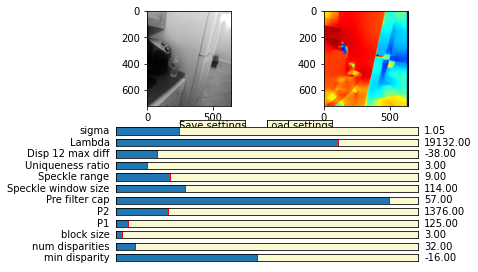

In [11]:
fig = plt.subplots(1,2)
if post_process:
    plt.subplots_adjust(left=0.15, bottom=0.55)
else:
    plt.subplots_adjust(left=0.15, bottom=0.5)
plt.subplot(1,2,1)
dmObject = plt.imshow(left_for_matcher, 'gray')

def get_stereo_map():
  sgbm = StereoSGBM(min_disp=min_disp, max_disp=num_disp, window_size=window_size, p1=p1, p2=p2, pre_filter_cap=pre_filter_cap, speckle_window_size=speckle_window_size, speckle_range=speckle_range, uniqueness_ratio=uniqueness_ratio, disp_12_max_diff=disp_12_max_diff)
  matcher = Matcher(sgbm)
  left_disp, right_disp, left_matcher = builder.match(left_for_matcher, right_for_matcher, matcher, metrics=False)
  # To postprocess
  if post_process:
    left_disp = builder.post_process(left_for_matcher, left_disp, right_disp, left_matcher, lmbda=lmbda, sigma=sigma, metrics=False)
  if downsample in [1, None, False]:
    n_upsamples = 0
  else:
    n_upsamples = [2**p for p in range(1, 7)].index(downsample)
    n_upsamples += 1
  if n_upsamples > 0:
    for i in range(n_upsamples):
      left_disp = cv.pyrUp(left_disp)
  left_disp = builder.estimate_disparity_colormap(left_disp)
  return left_disp

def load_settings(event):
  global min_disp, num_disp, window_size, p1, p2, pre_filter_cap, speckle_range, uniqueness_ratio, disp_12_max_diff, speckle_window_size, loading_settings, lmbda, sigma
  loading_settings = 1
  file_name = 'SGBM_disparity_parameters_set.txt'
  print('Loading parameters from file...')
  button_load.label.set_text ("Loading...")
  f=open(file_name, 'r')
  data = json.load(f)
  slider_min_disparity.set_val(data['minDisparity'])
  slider_num_disparity.set_val(data['numberOfDisparities'])
  slider_block_size.set_val(data['windowSize'])
  slider_p1.set_val(data['p1'])
  slider_p2.set_val(data['p2'])
  slider_pre_filter_cap.set_val(data['preFilterCap'])
  slider_speckle_window_size.set_val(data['speckleWindowSize'])
  slider_speckle_range.set_val(data['speckleRange'])
  slider_uniqueness_ratio.set_val(data['uniquenessRatio'])
  slider_disp_12_max_diff.set_val(data['disp12MaxDiff'])
  if post_process:
    slider_lambda.set_val(data['lambda'])
    slider_sigma.set_val(data['sigma'])
  f.close()
  button_load.label.set_text ("Load settings")
  print ('Parameters loaded from file '+ file_name)
  print ('Redrawing depth map with loaded parameters...')
  loading_settings = 0
  update(0)
  print ('Done!')

def save_settings(event):
  button_save.label.set_text ("Saving...")
  print('Saving to file...') 
  result = json.dumps({'windowSize' : window_size, 'preFilterCap' : pre_filter_cap, \
        'minDisparity' : min_disp, 'numberOfDisparities' : num_disp, 'p1' : p1, \
        'p2' : p2, 'uniquenessRatio': uniqueness_ratio, 'disp12MaxDiff' : disp_12_max_diff, \
        'speckleRange': speckle_range, 'speckleWindowSize': speckle_window_size, 'lambda': lmbda, 'sigma': sigma},\
        sort_keys=True, indent=4, separators=(',',':'))
  file_name = 'SGBM_disparity_parameters_set.txt'
  f = open (str(file_name), 'w') 
  f.write(result)
  f.close()
  button_save.label.set_text ("Save to file")
  print ('Settings saved to file ' + file_name)
    
axcolor = 'lightgoldenrodyellow'
if post_process:
    save_axe = plt.axes([0.3, 0.46, 0.15, 0.04]) #stepX stepY width height
    button_save = Button(save_axe, 'Save settings', color=axcolor, hovercolor='0.975')
    button_save.on_clicked(save_settings)
    load_axe = plt.axes([0.5, 0.46, 0.15, 0.04]) #stepX stepY width height
    button_load = Button(load_axe, 'Load settings', color=axcolor, hovercolor='0.975')
    button_load.on_clicked(load_settings)
else:
    save_axe = plt.axes([0.3, 0.38, 0.15, 0.04]) #stepX stepY width height
    button_save = Button(save_axe, 'Save settings', color=axcolor, hovercolor='0.975')
    button_save.on_clicked(save_settings)
    load_axe = plt.axes([0.5, 0.38, 0.15, 0.04]) #stepX stepY width height
    button_load = Button(load_axe, 'Load settings', color=axcolor, hovercolor='0.975')
    button_load.on_clicked(load_settings)

disparity = get_stereo_map()
plt.subplot(1,2,2)
dmObject = plt.imshow(disparity)
#dmObject = plt.imshow(disparity, "gray")

min_disparity_axe = plt.axes([0.15, 0.01, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
num_disparity_axe = plt.axes([0.15, 0.05, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
block_size_axe = plt.axes([0.15, 0.09, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
p1_axe = plt.axes([0.15, 0.13, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
p2_axe = plt.axes([0.15, 0.17, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
pre_filter_cap_axe = plt.axes([0.15, 0.21, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
speckle_window_size_axe = plt.axes([0.15, 0.25, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
speckle_range_axe = plt.axes([0.15, 0.29, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
uniqueness_ratio_axe = plt.axes([0.15, 0.33, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
disp_12_max_diff_axe = plt.axes([0.15, 0.37, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
if post_process:
  lambda_axe = plt.axes([0.15, 0.41, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height
  sigma_axe = plt.axes([0.15, 0.45, 0.7, 0.025], facecolor=axcolor) #stepX stepY width height

slider_min_disparity = Slider(min_disparity_axe, "min disparity", -256, 256, valinit=min_disp)
slider_num_disparity = Slider(num_disparity_axe, "num disparities", 0, 512, valinit=num_disp)
slider_block_size = Slider(block_size_axe, "block size", 2, 51, valinit=window_size)
slider_p1 = Slider(p1_axe, "P1", 0, 3000, valinit=p1)
slider_p2 = Slider(p2_axe, "P2", 0, 8000, valinit=p2)
slider_pre_filter_cap = Slider(pre_filter_cap_axe, "Pre filter cap", 0, 63, valinit=pre_filter_cap)
slider_speckle_window_size = Slider(speckle_window_size_axe, "Speckle window size", 0, 500, valinit=speckle_window_size)
slider_speckle_range = Slider(speckle_range_axe, "Speckle range", 0, 50, valinit=speckle_range)
slider_uniqueness_ratio = Slider(uniqueness_ratio_axe, "Uniqueness ratio", 1, 20, valinit=uniqueness_ratio)
slider_disp_12_max_diff = Slider(disp_12_max_diff_axe, "Disp 12 max diff", -64, 128, valinit=disp_12_max_diff)
if post_process:
  slider_lambda = Slider(lambda_axe, "Lambda", 0, 26000, valinit=lmbda)
  slider_sigma = Slider(sigma_axe, "sigma", 0, 5, valinit=sigma)

def update(val):
  global min_disp, num_disp, window_size, p1, p2, pre_filter_cap, speckle_range, uniqueness_ratio, disp_12_max_diff, speckle_window_size,lmbda, sigma
  #update sliders
  min_disp = int(slider_min_disparity.val)
  num_disp = int(slider_num_disparity.val/16)*16
  if slider_block_size.val % 2 == 0:
    slider_block_size.val += 1
  window_size = int(slider_block_size.val)
  p1 = int(slider_p1.val)
  p2 = int(slider_p2.val)
  pre_filter_cap = int(slider_pre_filter_cap.val)
  speckle_window_size = int(slider_speckle_window_size.val)
  speckle_range = int(slider_speckle_range.val)
  uniqueness_ratio = int(slider_uniqueness_ratio.val)
  disp_12_max_diff = int(slider_disp_12_max_diff.val)
  if post_process:
    lmbda = slider_lambda.val
    sigma = slider_sigma.val
  assert ValueError
  if (loading_settings==0):
    print ('Rebuilding depth map')
    disparity = get_stereo_map()
    dmObject.set_data(disparity)
    print ('Redraw depth map')
    plt.draw()

slider_min_disparity.on_changed(update)
slider_num_disparity.on_changed(update)
slider_block_size.on_changed(update)
slider_p1.on_changed(update)
slider_p2.on_changed(update)
slider_pre_filter_cap.on_changed(update)
slider_speckle_window_size.on_changed(update)
slider_speckle_range.on_changed(update)
slider_uniqueness_ratio.on_changed(update)
slider_disp_12_max_diff.on_changed(update)

if post_process:
  slider_lambda.on_changed(update)
  slider_sigma.on_changed(update)

print('Show interface to user')
plt.show()

# Lesson 3: Disparity maps
Her you will learn how to get a disparity map using StereoController, StandardStereoBuilder and Matcher:

> StereoController(): This class is to implement each necessary step to get a disparity map, 3D map, points in homogeneous coordinates or a disparity map in color

> StandardStereoBuilder(cam_left: Camera, cam_right: Camera, stereo_maps_path):
  Implement methods to get depth using OpenCV matchers like SGBM or BM.

> Arguments:
- camL: left camera instance.
- camR: right camera instance.
- stereo_maps_path: an xml with Stereo rectification maps

> Matcher(strategy: MatcherStrategy)
- MatcherStrategy is a class like StereoSGBM
> StereoSGBM(min_disp=0, max_disp=160, window_size=3, p1=24*3*3, p2=96*3*3, pre_filter_cap=63, mode=cv.StereoSGBM_MODE_HH, speckle_window_size=1100, speckle_range=1, uniqueness_ratio=5, disp_12_max_diff=-1)

> Arguments:
- min_disp: Minimum possible disparity value. Normally, it is zero but sometimes rectification algorithms can shift images, so this parameter needs to be adjusted accordingly.
- max_disp: Maximum disparity minus minimum disparity. The value is always greater than zero. In the current implementation, this parameter must be divisible by 16.
- window_size: Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
- p1: The first parameter controlling the disparity smoothness. 
- p2: 	The second parameter controlling the disparity smoothness. The larger the values are, the smoother the disparity is. P1 is the penalty on the disparity change by plus or minus 1 between neighbor pixels. P2 is the penalty on the disparity change by more than 1 between neighbor pixels. The algorithm requires P2 > P1 . See stereo_match.cpp sample where some reasonably good P1 and P2 values are shown (like 8*number_of_image_channels*SADWindowSize*SADWindowSize and 32*number_of_image_channels*SADWindowSize*SADWindowSize , respectively).
- pre_filter_cap: Truncation value for the prefiltered image pixels. The algorithm first computes x-derivative at each pixel and clips its value by [-preFilterCap, preFilterCap] interval. The result values are passed to the Birchfield-Tomasi pixel cost function.
- mode: Set it to StereoSGBM_MODE_HH to run the full-scale two-pass dynamic programming algorithm. It will consume O(W*H*numDisparities) bytes, which is large for 640x480 stereo and huge for HD-size pictures. By default, it is set to false .
- speckle_window_size: Maximum size of smooth disparity regions to consider their noise speckles and invalidate. Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
- speckle_range: Maximum disparity variation within each connected component. If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16. Normally, 1 or 2 is good enough.
- uniqueness_ratio: Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct. Normally, a value within the 5-15 range is good enough.
- disp_12_max_diff: Maximum allowed difference (in integer pixel units) in the left-right disparity check. Set it to a non-positive value to disable the check.

In [12]:
# First calibrate and rectify
left_camera = Camera("left_camera", "PUT_AN_LEFT_IMAGE_PATH")
right_camera = Camera("right_camera", "PUT_AN_RIGHT_IMAGE_PATH")
stereo_pair_fisheye = StandardStereo(left_camera, right_camera)
stereo_maps_path = "/content/stereoMap"
stereo_pair_fisheye.calibrate("LEFT_CAMERA_CALIBRATION_IMAGES_FOLDER", "RIGHT_CAMERA_CALIBRATION_IMAGES_FOLDER", show=False)
stereo_pair_fisheye.rectify((640, 720), (640, 720), export_file=True, export_file_name=stereo_maps_path)
builder = StandardStereoBuilder(left_camera, right_camera, stereo_maps_path + ".xml")

Calibrating estereo...
Camera parameters hasn't fixed
Fixing left camera...
Left camera error 0.196044268885419
Fixing Right camera...
Right camera error 0.18532068709086463
Calibrating estereo...
system calibrated
Saving parameters!


computing disparity...
matching time: 0.18806171417236328 s
postprocessing time: 0.018210649490356445 s


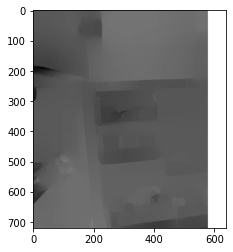

In [13]:
# Matching to get a disparity map in black an white
sgbm = StereoSGBM(-63, 64, 3, 27, 519, 10, cv.StereoSGBM_MODE_HH, 0, 22, 1, 70)
matcher = Matcher(sgbm)
stereo_controller = StereoController()
stereo_controller.stereo_builder = builder
frame_left = cv.imread(left_camera.source)
frame_right = cv.imread(right_camera.source)
disparity, _ = stereo_controller.compute_disparity(frame_left, frame_right, matcher, None, 22386, 1.242, True, True)
plt.imshow(disparity, "gray")
plt.show()

computing disparity...
matching time: 0.18427491188049316 s
postprocessing time: 0.01621556282043457 s


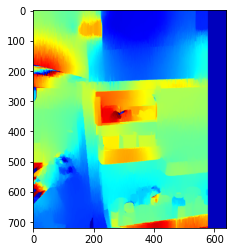

In [14]:
# Matching to get a disparity color map
disparity_color, _ = stereo_controller.compute_disparity_color_map(frame_left, frame_right, matcher, None, 22386, 1.242, True, True)
plt.imshow(disparity_color)
plt.show()